# Training a YOLOX Model

In this notebook we will run the YOLOX pretrained on some items locally.  
We will then finetune the model on a custom dataset and upload the new snapshot to Dataloop platform

In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import logging
import sys
import dtlpy as dl
from dtlpy.ml import train_utils

# Get Global Model and Pretrained Snapshot

Get the global model and snapshot from the platform.  
"list()" followed by the "to_df()" method will return pandas DataFrame to view the Dataloop entities and 

In [2]:
model = dl.models.get(model_name='YOLOX')
model.snapshots.list().to_df()
snapshot = model.snapshots.get(snapshot_name='coco-pretrained')
snapshot.to_df()

2021-08-26 18:24:21.050 [WARNING]-[ThreadPoolExecutor-0_0]-[v1.35.2]dtlpy.entities.codebase: git_tag was set None. Using default 'main'!


,id,creator,createdAt,name,description,is_global,status,tags,configuration,modelId,orgId,projectId,datasetId,bucket,ontologySpec
0,61276f969461ec3aaf6f7301,or@dataloop.ai,2021-08-26T10:40:22.937Z,coco-pretrained,COCO pretrained model,False,created,[],"{'ckpt': 'yolox_l.pth', 'classes_filename': 'c...",6127681e9461ec68cc6f7300,18739a63-4393-43ea-a87e-9a284b14978f,729659ec-6d7f-11e8-8d00-42010a8a002b,None,"{'type': 'gcs', 'gcsProjectName': 'viewo-main'...","{'labels': ['person', 'bicycle', 'car', 'motor..."


# Load the Pretrained Snapshot for Inference

Once we have the Dataloop entities, we can load the Model Adapter using the "build()" method.  
This will create an instance of the model class with "train()", "inference()" and more functions we can use 

In [27]:
adapter = model.build()
adapter.load_from_snapshot(snapshot=snapshot)

## Inference and Upload Annotations to Item

In [ ]:
# upload coco item and inference
item = dl.items.get(item_id='611e174e4c09acc3c5bb81d3')

# use the dapter to inference with uploading annotations
annotations = adapter.predict_items([item], with_upload=True)

View inference results and plot on the item

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1865.79it/s]


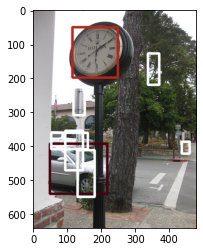

In [5]:
image = np.asarray(Image.open(item.download()))
plt.imshow(item.annotations.show(image=image,
                                 thickness=5))

# Run Training on Custom Dataset

We will use the Fruit Images dataset, which is ready to upload with annotation in the Dataloop format.  
First we'll create new project and dataset and upload the images with anntoations

In [4]:
project = dl.projects.create('Fruits Proj')
dataset = project.datasets.create('FruitImage')
items = dataset.items.upload(local_path='../../assets/sample_datasets/FruitImage/items/*',
                             local_annotations_path='../../assets/sample_datasets/FruitImage/json')

In [8]:
dataset.ontologies.list()[0].add_labels(['apple', 'orange', 'banana'])

In [7]:
dataset.labels

[Label(tag='apple', display_data={}, color='#e0b515', display_label='apple', attributes=[], children=[]),
 Label(tag='orange', display_data={}, color='#69e3c7', display_label='orange', attributes=[], children=[]),
 Label(tag='banana', display_data={}, color='#b33d14', display_label='banana', attributes=[], children=[])]

# Prepare New Dataset for Training

The "prepare_dataset()" method prepares the raw dataset to be a part of a snapshot and ready for training.  
This will:
1. Clone the dataset to prepare 
1. Create train, validation and test splits
1. Lock the dataset to be read only

We can set the partition split to be random (using float to set the precentage) or we can use DQL filters to set specific items and folder

In [5]:
# split the dataset to 2 partitions - 80% train 20% validation
partitions = {dl.SnapshotPartitionType.TRAIN: 0.8,
              dl.SnapshotPartitionType.VALIDATION: 0.2}

# use DQL to set the two directories and the train/val split
partitions = {dl.SnapshotPartitionType.TRAIN: dl.Filters(field='dir', values='/train'),
              dl.SnapshotPartitionType.VALIDATION: dl.Filters(field='dir', values='/test')}
    
cloned_dataset = train_utils.prepare_dataset(dataset,
                                             filters=None,
                                             partitions=partitions)

2021-08-26 18:25:05.487 [WARNING]-[MainThread]-[v1.35.2]dtlpy.ml.train_utils: Cloned dataset already exist. Using it...


Cloning the pretrained snapshot to create a new snapshot for our custom dataset.  
When cloning we can change any parameter to the new snapshot. here we will change the dataset for our cloned one

In [28]:
snapshot_name='fruit-first'
bucket = project.buckets.create(model_name=model.name,
                                snapshot_name=snapshot_name)
new_snapshot = snapshot.clone(snapshot_name=snapshot_name,
                              dataset_id=cloned_dataset.id,
                              bucket=bucket,
                              configuration={'batch_size': 2,
                                             'start_epoch': 0,
                                             'max_epoch': 5,
                                             'input_size': (256, 256)})
new_snapshot = model.snapshots.get(snapshot_name=snapshot_name)

We can easily list the content of the new cloned snapshtop:

In [33]:
new_snapshot.bucket.list_content().to_df()

,createdAt,datasetId,annotated,filename,name,type,id,hidden,dir,annotationsCount,dataset
0,2021-08-26T14:12:29.000Z,5d467a64862d1b60ddbbe9ca,False,/artifacts/models/YOLOX/snapshots/fruit-first/...,classes.json,file,6127a14df3561d9d608a2de3,False,/artifacts/models/YOLOX/snapshots/fruit-first,0,https://gate.dataloop.ai/api/v1/datasets/5d467...
1,2021-08-26T14:13:07.000Z,5d467a64862d1b60ddbbe9ca,False,/artifacts/models/YOLOX/snapshots/fruit-first/...,yolox_l.pth,file,6127a17365254c50e991b0aa,False,/artifacts/models/YOLOX/snapshots/fruit-first,0,https://gate.dataloop.ai/api/v1/datasets/5d467...


We will load the new snapshot to the adapter and preprare the snapshot for training.  
This will:
1. download the dataset lcoally
1. run the adapter's "convert_from_dtlpy()" if we need to convert the dataloop format to another format

In [11]:
adapter.load_from_snapshot(snapshot=new_snapshot)
root_path, data_path, output_path = adapter.prepare_training()

W: dtlpy.ml.base_model_adapter 18:26:57 [base_model_adapter.py:49](snapshot):: Replacing snapshot from 'fruit-first' to 'fruit-first'
2021-08-26 18:26:57.380 [WARNING]-[MainThread]-[v1.35.2]dtlpy.ml.base_model_adapter: Replacing snapshot from 'fruit-first' to 'fruit-first'
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 657.16it/s]
2021-08-26 18:26:57.610 | INFO     | ModelAdapter:load:111 - Args: <ModelAdapter.Dummy object at 0x000001F69FD0F508>
2021-08-26 18:26:57.999 | INFO     | ModelAdapter:load:121 - Model Summary: Params: 54.21M, Gflops: 155.65
2021-08-26 18:26:57.999 | INFO     | ModelAdapter:load:132 - loading checkpoint
2021-08-26 18:26:58.254 | INFO     | ModelAdapter:load:136 - loaded checkpoint done.
W: dtlpy.ml.base_model_adapter 18:26:58 [base_model_adapter.py:173](prepare_training):: Data path dire

## Start Training
now we're ready to train

In [12]:
# Start the Train
print("Training {!r} with snapshot {!r} on data {!r}".format(model.name, new_snapshot.id, data_path))
adapter.train(data_path=data_path,
              output_path=output_path)

 10%|███████████████████▌                                                                                                                                                                                | 10/100 [00:00<00:00, 99.04it/s]

Training 'YOLOX' with snapshot '6127b2729461ec2df56f730f' on data 'C:\\Users\\Shabtay\\.dataloop\\datasets\\612777685f978bfdfa6c3543'


2021-08-26 18:26:59 | INFO     | yolox.core.trainer:126 - args: <ModelAdapter.Dummy object at 0x000001F6A7E75608>
2021-08-26 18:26:59 | INFO     | yolox.core.trainer:127 - exp value:
╒══════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ keys             │ values                                                                                                                                                                                                                                │
╞══════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ seed             │ None                                 

2021-08-26 18:27:00 | INFO     | yolox.core.trainer:133 - Model Summary: Params: 54.15M, Gflops: 24.85
2021-08-26 18:27:01 | INFO     | yolox.core.trainer:287 - loading checkpoint for fine tuning
2021-08-26 18:27:01 | WARNING  | yolox.utils.checkpoint:26 - Shape of head.cls_preds.0.weight in checkpoint is torch.Size([80, 256, 1, 1]), while shape of head.cls_preds.0.weight in model is torch.Size([3, 256, 1, 1]).
2021-08-26 18:27:01 | WARNING  | yolox.utils.checkpoint:26 - Shape of head.cls_preds.0.bias in checkpoint is torch.Size([80]), while shape of head.cls_preds.0.bias in model is torch.Size([3]).
2021-08-26 18:27:01 | WARNING  | yolox.utils.checkpoint:26 - Shape of head.cls_preds.1.weight in checkpoint is torch.Size([80, 256, 1, 1]), while shape of head.cls_preds.1.weight in model is torch.Size([3, 256, 1, 1]).
2021-08-26 18:27:01 | WARNING  | yolox.utils.checkpoint:26 - Shape of head.cls_preds.1.bias in checkpoint is torch.Size([80]), while shape of head.cls_preds.1.bias in model 

2021-08-26 18:27:03 | INFO     | yolox.core.trainer:189 - ---> start train epoch1
2021-08-26 18:27:03 | INFO     | yolox.core.trainer:192 - --->No mosaic aug now!
2021-08-26 18:27:03 | INFO     | yolox.core.trainer:194 - --->Add additional L1 loss now!

 10%|███████████████████▌                                                                                                                                                                                | 10/100 [00:05<00:46,  1.92it/s]
2021-08-26 18:27:07 | INFO     | yolox.core.trainer:247 - epoch: 1/5, iter: 10/120, mem: 5401Mb, iter_time: 0.414s, data_time: 0.026s, total_loss: 9.4, iou_loss: 1.5, l1_loss: 0.9, conf_loss: 3.0, cls_loss: 4.0, lr: 8.681e-08, size: 256, ETA: 0:04:03
 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 95/100 [00:10<00:00,  9.14it/s]
2021-08-26 18:27:17 | INF

2021-08-26 18:29:03 | INFO     | yolox.core.trainer:247 - epoch: 3/5, iter: 20/120, mem: 5945Mb, iter_time: 0.235s, data_time: 0.030s, total_loss: 5.3, iou_loss: 1.5, l1_loss: 1.1, conf_loss: 2.0, cls_loss: 0.6, lr: 5.868e-05, size: 672, ETA: 0:02:31
2021-08-26 18:29:05 | INFO     | yolox.core.trainer:247 - epoch: 3/5, iter: 30/120, mem: 5945Mb, iter_time: 0.142s, data_time: 0.023s, total_loss: 5.6, iou_loss: 1.9, l1_loss: 0.9, conf_loss: 1.8, cls_loss: 1.0, lr: 6.328e-05, size: 480, ETA: 0:02:22
2021-08-26 18:29:07 | INFO     | yolox.core.trainer:247 - epoch: 3/5, iter: 40/120, mem: 5945Mb, iter_time: 0.218s, data_time: 0.018s, total_loss: 4.3, iou_loss: 1.4, l1_loss: 0.7, conf_loss: 1.5, cls_loss: 0.7, lr: 6.806e-05, size: 640, ETA: 0:02:16
2021-08-26 18:29:10 | INFO     | yolox.core.trainer:247 - epoch: 3/5, iter: 50/120, mem: 5945Mb, iter_time: 0.252s, data_time: 0.042s, total_loss: 6.4, iou_loss: 1.4, l1_loss: 0.8, conf_loss: 3.2, cls_loss: 1.1, lr: 7.300e-05, size: 704, ETA: 0:02

2021-08-26 18:30:21 | INFO     | yolox.core.trainer:247 - epoch: 5/5, iter: 60/120, mem: 5945Mb, iter_time: 0.250s, data_time: 0.035s, total_loss: 11.4, iou_loss: 3.3, l1_loss: 2.7, conf_loss: 4.4, cls_loss: 1.0, lr: 2.531e-04, size: 704, ETA: 0:00:20
2021-08-26 18:30:24 | INFO     | yolox.core.trainer:247 - epoch: 5/5, iter: 70/120, mem: 5945Mb, iter_time: 0.314s, data_time: 0.029s, total_loss: 13.8, iou_loss: 3.0, l1_loss: 3.0, conf_loss: 4.2, cls_loss: 3.6, lr: 2.626e-04, size: 800, ETA: 0:00:17
2021-08-26 18:30:26 | INFO     | yolox.core.trainer:247 - epoch: 5/5, iter: 80/120, mem: 5945Mb, iter_time: 0.209s, data_time: 0.022s, total_loss: 9.8, iou_loss: 2.3, l1_loss: 2.0, conf_loss: 4.4, cls_loss: 1.0, lr: 2.722e-04, size: 608, ETA: 0:00:13
2021-08-26 18:30:28 | INFO     | yolox.core.trainer:247 - epoch: 5/5, iter: 90/120, mem: 5945Mb, iter_time: 0.144s, data_time: 0.020s, total_loss: 8.1, iou_loss: 2.3, l1_loss: 1.5, conf_loss: 3.7, cls_loss: 0.6, lr: 2.820e-04, size: 480, ETA: 0:

In [36]:
adapter.snapshot.bucket.list_content().to_df()

,createdAt,datasetId,annotated,filename,name,type,id,hidden,dir,annotationsCount,dataset
0,2021-08-26T14:12:29.000Z,5d467a64862d1b60ddbbe9ca,False,/artifacts/models/YOLOX/snapshots/fruit-first/...,classes.json,file,6127a14df3561d9d608a2de3,False,/artifacts/models/YOLOX/snapshots/fruit-first,0,https://gate.dataloop.ai/api/v1/datasets/5d467...
1,2021-08-26T14:13:07.000Z,5d467a64862d1b60ddbbe9ca,False,/artifacts/models/YOLOX/snapshots/fruit-first/...,yolox_l.pth,file,6127a17365254c50e991b0aa,False,/artifacts/models/YOLOX/snapshots/fruit-first,0,https://gate.dataloop.ai/api/v1/datasets/5d467...


In [13]:
adapter.save_to_snapshot(local_path=output_path,
                         replace=True)

In [32]:
adapter.snapshot.bucket.list_content().to_df()

,createdAt,datasetId,annotated,filename,name,type,id,hidden,dir,annotationsCount,dataset
0,2021-08-26T15:31:12.000Z,5d467a64862d1b60ddbbe9ca,False,/artifacts/models/YOLOX/snapshots/fruit-first/...,classes.json,file,6127b3c0c0ee3a7251fcfddd,False,/artifacts/models/YOLOX/snapshots/fruit-first,0,https://gate.dataloop.ai/api/v1/datasets/5d467...
1,2021-08-26T15:31:12.000Z,5d467a64862d1b60ddbbe9ca,False,/artifacts/models/YOLOX/snapshots/fruit-first/...,events.out.tfevents.1629991623.DESKTOP-T0H7OEL...,file,6127b3c065254c305791b38e,False,/artifacts/models/YOLOX/snapshots/fruit-first,0,https://gate.dataloop.ai/api/v1/datasets/5d467...
2,2021-08-26T15:31:12.000Z,5d467a64862d1b60ddbbe9ca,False,/artifacts/models/YOLOX/snapshots/fruit-first/...,train_log.txt,file,6127b3c0115655eb6017a20f,False,/artifacts/models/YOLOX/snapshots/fruit-first,0,https://gate.dataloop.ai/api/v1/datasets/5d467...
3,2021-08-26T15:32:19.000Z,5d467a64862d1b60ddbbe9ca,False,/artifacts/models/YOLOX/snapshots/fruit-first/...,latest_ckpt.pth,file,6127b40365254c0eee91b391,False,/artifacts/models/YOLOX/snapshots/fruit-first,0,https://gate.dataloop.ai/api/v1/datasets/5d467...
4,2021-08-26T15:32:26.000Z,5d467a64862d1b60ddbbe9ca,False,/artifacts/models/YOLOX/snapshots/fruit-first/...,last_epoch_ckpt.pth,file,6127b40afe7ad11db79d6089,False,/artifacts/models/YOLOX/snapshots/fruit-first,0,https://gate.dataloop.ai/api/v1/datasets/5d467...


# Predict New Snapshot in Platform Item

In [46]:
item = dl.items.get(item_id='6110d4a41467ded7a8c2a23d')
adapter.load_from_snapshot(snapshot=new_snapshot)

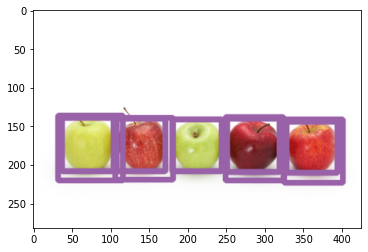

In [47]:
annotations = adapter.predict_items([item], with_upload=True)
image = Image.open(item.download())
plt.imshow(item.annotations.show(np.asarray(image),
                                 thickness=5))